In [1]:
from scipy.io.wavfile import read
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import pandas as pd 
import csv 
from scipy.io.wavfile import write # For writing to a .wav file
from scipy import fft
from scipy import ifft

In [3]:
a = read("audio_file.wav")
audio_array = np.array(a[1],dtype=float)
OFDM_RX = audio_array 

#### Defining constants 

In [4]:
# Define constants
N = 1024 #OFDM symbol length
L = 32 #Cyclic prefix length
n = 50 # Number of repetitions of OFDM symbol for transmission
sample_rate = 44100 # Sample rate is 44.1 kHz
P = 16 # number of pilot carriers per OFDM block
pilot_value = 3+3j # The known value each pilot transmits
n = 50 # Number of repetitions of OFDM symbol for transmission

#### Generating random transmitted signal 

In [5]:
# Generate an array of 511 random constellation symbols with '0' as the first element.
# 'A' is the radius of the QPSK constellation circle.

def generate_random_sequence(N, QPSK=True, A=1):
    """Takes the size of OFDM symbol length, assuming QPSK encoding and returns array of random constellation symbols"""
    block_size = int(N / 2 - 1) # Set size of block to OFDM symbol length divided by 2 for mirroring and subtract 1 to have zeroed first entry
    random_constellation_indices = np.random.randint(4, size=block_size) # Generate 511 random indices for the QPSK constellation
    mapping = [A/np.sqrt(2)*(1+1j), A/np.sqrt(2)*(-1+1j), A/np.sqrt(2)*(-1-1j), A/np.sqrt(2)*(1-1j)] # Define the mapping of indices to QPSK constellation

    mapping = np.array(mapping)

    random_sequence = np.array([0]) # Set up first element to be constellation symbol corresponding to zero !!!(is this right?)!!!

    for index in random_constellation_indices:
      random_sequence = np.append(random_sequence, mapping[index])

    return random_sequence

random_sequence = generate_random_sequence(N, QPSK=True, A=1)

# Takes an array and appends the flipped/reversed complex-conjugate array. The two concatenated arrays both begin with a '0'.
def generate_symmetric_sequence(sequence):
    """Takes a array sequence and appends a reversed form on the end"""
    reversed_sequence = np.conj(np.append(np.array([0]), np.flip(sequence[1:512]))) # Reverse the order of the input array, and take the complex conjugate.
    symmetric_sequence = np.append(sequence, reversed_sequence) # Append the flipped array to the original array.
    return symmetric_sequence

symmetric_sequence = generate_symmetric_sequence(random_sequence)


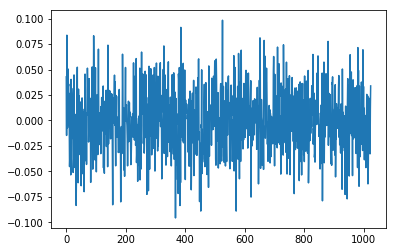

In [7]:
# Take N-point iDFT of the above array
def apply_inverse_dft(sequence):
    """Takes a N-point inverse discrete Fourier transform of a sequence, who's output is purely real"""
    time_domain_sequence = ifft(sequence) # Take inverse discrete Fourier transform

    time_domain_sequence = time_domain_sequence.real # Consider only real part given that it is supposed to be real
    return time_domain_sequence

time_domain_sequence = apply_inverse_dft(symmetric_sequence)


# Plot the resulting time-domain sequence.
fig, ax = plt.subplots()
x = np.linspace(0, N, num=N)
ax.plot(x, time_domain_sequence.real);
fig.show()

# Add cyclic prefix
def add_cyclic_prefix(sequence, N, L):
      # Takes sequence, the symbol length and cyclic prefix length L to insert cyclic prefix
    cyclic_prefix = sequence[-L:] # Generate cyclic prefix by taking last values
    OFDM_symbol = np.append(cyclic_prefix, sequence) # Create single OFDM symbol by joining cyclic prefix and sequence
    return OFDM_symbol

OFDM_symbol = add_cyclic_prefix(time_domain_sequence, N, L)



In [8]:
# Create the array to be transmitted by repeating the above OFDM symbol some number of times. (And including any elements needed for synchronization).

def generate_repeated_signal(OFDM_symbol, n):
    """Generate signal to be transmitted by repeating the OFDM symbol n times"""
    repeated_signal = np.array([]) # Repeats OFDM symbol n times
    for i in range(1,n):
        repeated_signal = np.append(repeated_signal, OFDM_symbol)
    return repeated_signal

repeated_signal = generate_repeated_signal(OFDM_symbol, n)

#print(repeated_signal[0])
#print(repeated_signal[N+L])
#print(repeated_signal[2*N+2*L])
#print(repeated_signal[3*N + 3*L])



In [9]:
# Convert the np array to wav file and output wav file
# Note have defined sample_rate as 44.1 kHz above and have imported 'write' function

def convert_array_to_wav(array, sample_rate):
  # Normalize the amplitude of the signal. (Check this!!!)
  max_amplitude_before_normalizing = np.amax(np.abs(array))
  normalized_max_amplitude = np.iinfo(np.int16).max

  normalized_array = (array / max_amplitude_before_normalizing) * normalized_max_amplitude

  # Convert the normalized array to a wav file.
  write("output.wav", sample_rate, normalized_array.astype(np.int16))


convert_array_to_wav(repeated_signal, sample_rate)

print(np.amax(repeated_signal))
print(np.amin(repeated_signal))



0.098332917185795
-0.09561316386136354


In [10]:
a = read("output.wav")
audio_array = np.array(a[1],dtype=float)
OFDM_RX = audio_array 


## Channel estimation using pilot OFDM carriers

In [11]:
all_carriers = np.arange(N)  # indices of all subcarriers ([0, 1, ... N-1])

pilot_carriers = all_carriers[::N//P] # Pilots is every (N/P)th carrier.

# for convenience of channel estimation, make the last carriers also be a pilot
pilot_carriers = np.hstack([pilot_carriers, np.array([all_carriers[-1]])])
P = P+1

# data carriers are all remaining carriers
data_carriers = np.delete(all_carriers, pilot_carriers)

print ("allCarriers:   %s" % all_carriers)
print ("pilotCarriers: %s" % pilot_carriers)
print ("dataCarriers:  %s" % data_carriers)


allCarriers:   [   0    1    2 ... 1021 1022 1023]
pilotCarriers: [   0   64  128  192  256  320  384  448  512  576  640  704  768  832
  896  960 1023]
dataCarriers:  [   1    2    3 ... 1020 1021 1022]


In [12]:
def removeCP(signal):
    # to do: adjust for the whole signal, not just one ofdm block
    return signal[L:(L+N)]
OFDM_RX_noCP = removeCP(OFDM_RX)

In [13]:
def DFT(OFDM_RX):
    return fft(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)
OFDM_demod[pilot_carriers] = pilot_value

#### Channel estimation

In [17]:
def channel_estimate(OFDM_demod):
    pilots = OFDM_demod[pilot_carriers]  # extract the pilot values from the received signal 
    Hest_at_pilots = pilots / pilot_value # divide by the transmitted pilot values
    print(Hest_at_pilots)
    Hest_abs = scipy.interpolate.interp1d(pilot_carriers, abs(Hest_at_pilots), kind='linear')(all_carriers)
    Hest_phase = scipy.interpolate.interp1d(pilot_carriers, np.angle(Hest_at_pilots), kind='linear')(all_carriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    return Hest
Hest = channel_estimate(OFDM_demod)
print(Hest[:50])
h_time = apply_inverse_dft(Hest)
print(h_time[:50])

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [26]:
def channel_estimate_all(OFDM_demod, transmitted_block): #transmitted block is known 
    pilots = OFDM_demod  # extract the pilot values from the received signal 
    Hest_at_pilots = pilots / transmitted_block # divide by the transmitted pilot values
    print(Hest_at_pilots)
    Hest_abs = abs(Hest_at_pilots)
    Hest_phase = np.angle(Hest_at_pilots)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    return Hest
transmitted_block = OFDM_demod #todo 
Hest = channel_estimate_all(OFDM_demod, transmitted_block)
print(Hest[:50])
h_time = apply_inverse_dft(Hest)
print(h_time[:50])

[1.+0.j 1.-0.j 1.-0.j ... 1.-0.j 1.-0.j 1.+0.j]
[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
[ 1.00000000e+00 -2.40560754e-18  7.03665726e-19 -6.83866554e-19
  0.00000000e+00 -1.38682675e-18 -1.02386517e-18 -1.33402379e-19
  0.00000000e+00 -3.03199116e-19  6.07745885e-19  3.37460929e-19
  0.00000000e+00  1.03684360e-19 -4.70771283e-19 -1.13877146e-18
  0.00000000e+00 -6.86600391e-19  7.19167576e-19 -2.09831574e-18
  0.00000000e+00  2.09801273e-19  2.30075168e-19  1.57791733e-19
  0.00000000e+00  1.09825614e-18  8.50372118e-19 -3.69448437e-19
  0.00000000e+00  4.01734756e-19  3.88595342e-19  1.73484545e-19
  0.00000000e+00  1.28213403e-19  4.78753839e-19 -4.83989614e-19
  0.0000000

In [18]:
def demapping_symbol(symbol):
    first_bit = 0 if symbol.imag >= 0 else 1
    second_bit = 0 if symbol.real >= 0 else 1
    return first_bit, second_bit

def demapping(sequence):
    output = []
    for f in sequence:
        first_bit, second_bit = demapping_symbol(f)
        output.append(first_bit)
        output.append(second_bit)
    return output

def split_signal(file, N, L):
    return np.array_split(file, len(file)/1056)

def disregard_cyclic_prefix(splitted_file, L):
    return [list(w[L:][0]) for w in splitted_file]

def apply_fft(splitted_file, N):
    fft_blocks = [fft(block, N) for block in splitted_file]
    return fft_blocks 

def equalize(fft_blocks, H):
    equalized_fft_blocks = [np.divide(r, H) for r in fft_blocks]
    return equalized_fft_blocks 


def disregard_freq_bins(equalized_fft_blocks):
    return [d[1:512] for d in equalized_fft_blocks]

def fft_file(file, H, N, L):
    """
    returns fft of the file, before ML mapping, fft is in chunks of OFDM blocks
    """
    split_signal_1056 = split_signal(file, N, L)
    split_signal_1024 = disregard_cyclic_prefix(split_signal_1056, L)
    fft_blocks = apply_fft(split_signal_1024, N)
    equalized_fft_blocks = equalize(fft_blocks, H)
    return disregard_freq_bins(equalized_fft_blocks)

def demap_fft(fft_signal):
    bits = []
    for d in fft_signal:
        bits.extend(demapping(d))
    return bits 

def bits_to_bytes(bits):
    bits_string = "".join((str(s) for s in bits))
    output_bytes = [bits_string[i : i + 8] for i in range(0, len(bits_string), 8)]
    output_bytes = bytearray([int(i, 2) for i in output_bytes])
    return output_bytes 

def file_to_decoded_bytes(file, H, N, L):
    fft_signal_unmaped = fft_file(file, H, N, L)
    fft_signal_demapped = demap_fft(fft_signal_unmaped)
    bytes_output = bits_to_bytes(fft_signal_demapped)
    return bytes_output


In [23]:
FILE_NAME = 'file3.csv'
file = pd.read_csv(FILE_NAME, header = None)
a = read("audio_file.wav")
audio_array = np.array(a[1],dtype=float)
OFDM_RX = audio_array 
output_bytes = file_to_decoded_bytes(file, Hest, N, L)

In [24]:
print(output_bytes)

bytearray(b'files/1984570931.tiff\x001\x1c\x99\x9c\x9c\x92\x00II*\x00>\xf4\x02\x00\x7f\n\xa0\xdd\xad\xf8G\xb6\r\x85P\r\x85Q\xa2\xde\x06\xa2\xdd\x04\xa3\xdd\r\x06\xbb_\r\xb8_\r\xb8^!\xdf\x06\xa0\xde\t\x9e\xe0\t\x9e\xe0\n\x9d\xe0\t\x9f\xde\x07\x9d\xda\x05\x9e\xdc"\x85\xcc&\x9f\xd9\x06\x9f\xd9\x05\x9e\xd8\x05\x9e\xd8\x04\x9d\xd7\x05\x9e\xd8\x05\x9e\xd8\x05\x9e\xd8\x05\x9e\xd8\x05\x9e\xd8\x05\x9e\xd8\x05\x9e\xd8\x05\x9e\xd8\x05\x9e\xd8\x05\x9e\xd8\x05\x9e\xd8\x05\x9e\xd8\x05\x9e\xd8\x05\x9eN\xa0\xc7N\x85\x9e\xd8\x04\x9d\xd7\x04\x9d\xd7\x04\x9d\x7f\xd5\x89\xc6C\xa8y\xbc];\xbe]9\xd7\x06\x9c\xd7\x07\x9b\xd7\t2\xbeQ0\xbcQ0\xbcQ0\x96\t\x9b\xd7\n\x9c\xd8\n\x9c\xd8\x0b\x9d\xd9\x0b\x9d\xd9\t\x9b\xd7\x08\x9a\xd6\n\xceW\x8c\xd9\xd7\n\x9c\xd8\x08\x9c\xd8\x06\x9a\xd6\x06\x9c\xd7\x06\x9c\xd7\x06\x9c\xd7\x07\x9d\xd8\x07\x9d\xd8\x07\x9d\xd8\x08\x9e\xd9\x07\x9d\xd8\x07\x9d\xd8\x07\x9d\xd8\x07\x9d\xd8\x07\x9d\xd8\x06\x9c\xd7\x06\x9c\xd7\x06\x9c\xd1\xa2\xc4A\xa6\x9d\xd7\x04\x9d\xd7\x04\x9d\xd7\x04\x9d\xd7\x